In [2]:
import sys
import logging
import time
import itertools
import os
import datetime
import functools


"""
Some runtime optimizations for CPU (using tur nodes)
os.environ["OMP_NUM_THREADS"] = 32
tf.config.threading.set_inter_op_parallelism_threads(32)
tf.config.threading.set_intra_op_parallelism_threads(16)
tf.config.set_soft_device_placement(enabled)
tf.config.optimizer.set_jit(
    True
)
"""

import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import time
import os
import matplotlib.pyplot as plt


sys.path.append("../../")
import covid19_npis


In [3]:
""" # Debugging and other snippets
"""


# Logs setup
log = logging.getLogger()
# Needed to set logging level before importing other modules
# log.setLevel(logging.DEBUG)
covid19_npis.utils.setup_colored_logs()
logging.getLogger("parso.python.diff").disabled = True
# Mute Tensorflow warnings ...
# logging.getLogger("tensorflow").setLevel(logging.ERROR)


if tf.executing_eagerly():
    log.warning("Running in eager mode!")

2021-05-27 08:53:37 wollex root[5962] WARNING Running in eager mode!


In [29]:
""" # 1. Data Retrieval
    Load data for different countries/regions, for now we have to define every
    country by hand maybe we want to automatize that at some point.

    TODO: maybe we want to outsource that to a different file at some point
"""

# Load our data from csv files into our own custom data classes

countries = [
    "Germany",
    "Belgium",
    #    "Czechia",
    # "Denmark",
    # "Finland",
    # "Greece",
    # "Italy",
    # "Netherlands",
    "Portugal",
    # "Romania",
    # "Spain",
    # "Sweden",
    "Switzerland",
]

c = [
    covid19_npis.data.Country(f"../../data/coverage_db/{country}",)
    for country in countries
]


2021-05-27 09:44:32 wollex covid19_npis.data[5962] INFO Loaded data for Germany.
2021-05-27 09:44:32 wollex covid19_npis.data[5962] INFO Loaded data for Belgium.
2021-05-27 09:44:32 wollex covid19_npis.data[5962] INFO Loaded data for Portugal.
2021-05-27 09:44:33 wollex covid19_npis.data[5962] INFO Loaded data for Switzerland.


In [30]:
# Construct our modelParams from the data.
modelParams = covid19_npis.ModelParams(countries=c, minimal_daily_deaths=1)
# modelParams = covid19_npis.ModelParams.from_folder("../data/Germany_bundesländer/")

# Define our model
this_model = covid19_npis.model.model.main_model(modelParams)

# Test shapes, should be all 3:
def print_dist_shapes(st):
    for name, dist in itertools.chain(
        st.discrete_distributions.items(), st.continuous_distributions.items(),
    ):
        if dist.log_prob(st.all_values[name]).shape != (3,):
            log.warning(
                f"False shape: {dist.log_prob(st.all_values[name]).shape}, {name}"
            )
    for p in st.potentials:
        if p.value.shape != (3,):
            log.warning(f"False shape: {p.value.shape} {p.name}")


_, sample_state = pm.evaluate_model_transformed(this_model, sample_shape=(3,))
print_dist_shapes(sample_state)

In [31]:
"""  # 2. MCMC Sampling
"""
num_chains = 6
use_VI = True

if use_VI:
    (
        posterior_approx,
        bijector,
        transformed_names,
    ) = covid19_npis.model.build_approximate_posterior(this_model)

    sample_size = 50

    (
        logpfn,
        init_random,
        _deterministics_callback,
        deterministic_names,
        state_,
    ) = pm.mcmc.samplers.build_logp_and_deterministic_functions(
        this_model, num_chains=sample_size, collect_reduced_log_prob=False
    )

    trace_loss = lambda traceable_quantities: tf.debugging.check_numerics(
        traceable_quantities.loss, f"loss not finite: {traceable_quantities.loss}"
    )

    # For eventual debugging:
    # tf.config.run_functions_eagerly(True)
    # tf.debugging.enable_check_numerics(stack_height_limit=50, path_length_limit=50)

    begin = time.time()
    posterior = tfp.vi.fit_surrogate_posterior(
        logpfn,
        posterior_approx,
        tf.optimizers.Adam(
            learning_rate=0.0001, epsilon=0.1, beta_1=0.9, beta_2=0.999, clipvalue=10.0
        ),
        4000,
        convergence_criterion=None,
        sample_size=sample_size,
        trainable_variables=None,
        # jit_compile=False,
        variational_loss_fn=functools.partial(
            tfp.vi.monte_carlo_variational_loss,
            discrepancy_fn=tfp.vi.kl_reverse,
            use_reparameterization=True,
        ),
        trace_fn=trace_loss,
    )
    print(f"Runtime: {time.time() - begin:.3f} s")

    _, st = pm.evaluate_model_posterior_predictive(
        this_model, values=posterior_approx.sample(100)
    )
    var_names = list(st.all_values.keys()) + list(st.deterministics_values.keys())
    samples = {
        k: (
            st.untransformed_values[k]
            if k in st.untransformed_values
            else (
                st.deterministics_values[k]
                if k in st.deterministics_values
                else st.transformed_values[k]
            )
        )
        for k in var_names
    }
    from tensorflow_probability import bijectors as tfb

    init_state = posterior_approx.sample(num_chains)
    init_state = [init_state[name] for name in transformed_names]
    bijector_to_list = tfb.Restructure(
        [name for name in transformed_names], {name: name for name in transformed_names}
    )
    bijector_list = tfb.Chain(
        [bijector_to_list, bijector, tfb.Invert(bijector_to_list)]
    )

else:
    bijector_list = None
    init_state = None

DecodeError: Error parsing message

In [28]:
begin_time = time.time()
log.info("start")


trace_tuning, trace = pm.sample(
    this_model,
    num_samples=1000,
    num_samples_binning=10,
    burn_in_min=10,
    burn_in=2000,
    use_auto_batching=False,
    num_chains=num_chains,
    xla=False,
    initial_step_size=0.001,
    ratio_tuning_epochs=1.3,
    max_tree_depth=4,
    decay_rate=0.75,
    target_accept_prob=0.75,
    step_size_adaption_per_chain=False,
    bijector=bijector_list,
    init_state=init_state
    # num_steps_between_results = 9,
    #    state=pm.evaluate_model_transformed(this_model)[1]
    # sampler_type="nuts",
)

end_time = time.time()
log.info("running time: {:.1f}s".format(end_time - begin_time))

2021-05-27 09:34:30 wollex root[5962] INFO start
Auto-assigning NUTS sampler
2021-05-27 09:34:30 wollex pymc4.sampling[5962] INFO Auto-assigning NUTS sampler


init state:
main_model|__SoftPlus_sigma_likelihood_deaths
[-4.15767   -0.161322  -3.7678332 -1.0656345] 


2021-05-27 09:36:06 wollex pymc4.inference.sampling[5962] INFO Begin tuning
tuning windows: [ 10  20  20  30  30  40  50  70  90 110 140 180 240 310 400 520]
2021-05-27 09:36:06 wollex pymc4.sampling[5962] INFO tuning windows: [ 10  20  20  30  30  40  50  70  90 110 140 180 240 310 400 520]
log-like: -155646.4:   2%|▏         | 40/2260 [03:00<2:46:31,  4.50s/it]

KeyboardInterrupt: 

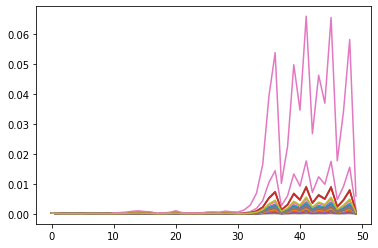

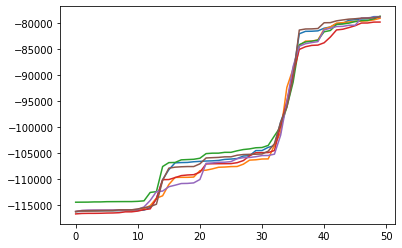

In [9]:
plt.figure()
plt.plot(trace_tuning.sample_stats["step_size"][0])
plt.figure()
plt.plot(trace_tuning.sample_stats["lp"].T)
plt.show(block=False)

In [10]:
# We also Sample the prior for the kde in the plots (optional)
trace_prior = pm.sample_prior_predictive(
    this_model, sample_shape=(500,), use_auto_batching=False
)

In [14]:
fpath = f'./../traces/{datetime.datetime.now().strftime("%y_%m_%d_%H")}'

# Save our traces for the plotting script
#store = covid19_npis.utils.save_trace_zarr(
store = covid19_npis.utils.save_trace(
    trace, modelParams, store=fpath, trace_prior=trace_prior,
)

2021-05-27 09:21:02 wollex covid19_npis.utils[5962] INFO Saved trace as 21_05_27_09_21 in ./../traces/21_05_27_09!


In [23]:
fpath='./traces/21_05_27_09/21_05_27_09_21'

In [22]:
cd notebooks/

/home/wollex/Data/Science/Corona/covid19_npis_europe/scripts/notebooks


In [24]:
os.system(f"python ./../plot_trace.py {fpath}")

0